In [1]:
from datasets import cilia, joint_transforms
from utils import training
from models import tiramisu
import adabound

import torch
from torchvision import transforms
from torch.utils import data
from imageio import imwrite, imread

from pathlib import Path
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
# Specify the path for folder
ROOT = '/home/afarahani/Projects/project2/dataset/data/data/'

RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

## Load the Data 
Training Data (input, mask)  
Validation Data (input, mask)  
Test Data (input)

In [3]:
train_joint_transformer = transforms.Compose([
    joint_transforms.JointRandomSizedCrop(256), 
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_cilia = cilia.Cilia(ROOT, joint_transform = train_joint_transformer)
train_loader = data.DataLoader(train_cilia, batch_size = 1, shuffle = True)

val_cilia = cilia.Cilia(ROOT, 'validate')
val_loader = torch.utils.data.DataLoader(val_cilia, batch_size=1, shuffle=True)

test_cilia = cilia.Cilia(ROOT, 'test')
test_loader = torch.utils.data.DataLoader(test_cilia, batch_size=1, shuffle=False)

Train: 1710
Val: 400
Test: 114
Inputs:  torch.Size([1, 1, 256, 256])
Targets:  torch.Size([1, 256, 256])


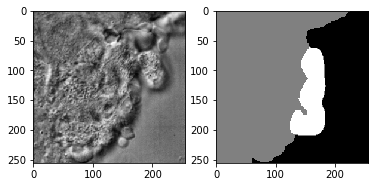

In [14]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

figure, subplot = plt.subplots(1,2)
subplot[0].imshow(inputs[0, 0, :, :], cmap = 'gray')
subplot[1].imshow(targets[0, :, :], cmap = 'gray')

## Training

In [15]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1000

### loss functions and optimizer

In [16]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.apply(training.weights_init)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
# criterion = FocalLoss()
# criterion = nn.NLLLoss(weight=torch.tensor([0.7, 0.2, 0.1]).cuda()).cuda()
criterion = torch.nn.NLLLoss().cuda()

In [17]:
train_acc, val_acc = [], []

for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = training.train(model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(epoch, trn_loss, 1 - trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    ### Validate ###
    val_loss, val_err = training.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1 - val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    
    train_acc.append(1 - trn_err)
    val_acc.append(1 - val_err)
    
    ### Checkpoint ###    
    training.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    training.adjust_learning_rate(LR, LR_DECAY, optimizer, epoch, DECAY_EVERY_N_EPOCHS)

KeyboardInterrupt: 

In [ ]:
x = list(range(1, 201))
plt.plot(x, train_acc, 'r', label='train accuracy')
plt.plot(x, val_acc, 'b', label='validation accuracy')
plt.legend()

In [ ]:
output_accu = np.zeros((len(train_acc), 3))
output_accu[:, 0] = np.arange(1, 201)
output_accu[:, 1] = np.array(train_acc)
output_accu[:, 2] = np.array(val_acc)
np.savetxt('adabound_accuracy.txt', output_accu)

## Test

In [ ]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.load_state_dict(torch.load('/home/afarahani/Projects/project2/team-linden-p2/src/tiramisu/.weights/weights-200-2.780-0.320.pth')['state_dict'])

In [ ]:
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, img in enumerate(test_loader):
    pred = training.get_test_pred(model, img)
    pred_img = pred[0, :, :]
    imwrite(os.path.join(RESULTS_PATH, test_dir[i] + '.png'), pred_img.numpy().astype(np.uint8))

In [ ]:
for test_hashcode in test_dir:
    test_frame_0 = imread(ROOT + 'test/data/' + test_hashcode + '/frame0000.png')
    test_mask = imread(ROOT + 'test/masks/' + test_hashcode + '.png')
    test_pred = imread(os.path.join(RESULTS_PATH, test_hashcode + '.png'))
    figure, subplot = plt.subplots(1,3)
    print(test_hashcode)
    subplot[0].imshow(test_frame_0, cmap='gray', aspect = 'equal')
    subplot[1].imshow(test_mask, cmap='gray', aspect = 'equal')
    subplot[2].imshow(test_pred, cmap='gray', aspect = 'equal')
    plt.show()